# Question 1
Below we demonstrate a Gibbs Sampler for the model, $$
x_i|\theta, \tau ∼ \mathit{N}(\theta, \frac{1}{\tau})$$
$$\pi(\theta, \tau) ∝ 1$$


*   $\theta \in \mathbb{R}$ is the Unknown mean.
*   $\tau = \frac{1}{\sigma^2} \in \mathbb{R}^{>0}$ is the unknown precision and $\sigma^2$ is the variance
* We assume uniform prior on both $\theta$ and $\tau$
* Conditional for $\theta$ is given by: $$θ| (\tau, \mathbb{x}) \sim \mathit{N}(\mathbb{\bar{x}}, \frac{1}{(n\tau)})$$
* Conditional for $\tau$ is given by:
$$\tau| (\theta, \mathbb{x}) \sim Gamma (\frac{n}{2}, \frac{2}{\sum_i(x_i - \theta)^2})$$

True mean: 5.0, Posterior mean estimate (theta): 4.919
True std dev: 2.0, Posterior std dev estimate: 1.868
95% Credible interval for theta: [4.661, 5.179]
95% Credible interval for tau:   [0.235, 0.348]


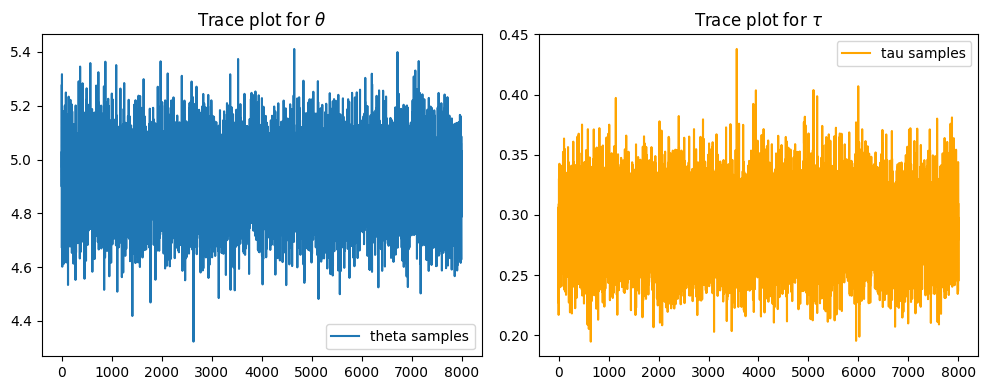

In [5]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def gibbs_sampler_normal_unknown_mean_precision(x, n_iter=10_000, init_theta=0.0, init_tau=1.0):
    """
    Perform Gibbs sampling for the Normal model with unknown mean (theta)
    and unknown precision (tau), under the prior p(theta, tau) ~ 1.

    Args:
        x (array-like): 1D array of observed data.
        n_iter (int): Number of Gibbs iterations.
        init_theta (float): Initial guess for theta.
        init_tau (float): Initial guess for tau (precision).

    Returns:
        thetas (ndarray): Samples of theta.
        taus   (ndarray): Samples of tau (precision).
    """
    x = np.asarray(x)
    n = len(x)

    # Arrays to store MCMC samples
    thetas = np.zeros(n_iter)
    taus   = np.zeros(n_iter)

    # Initialize
    thetas[0] = init_theta
    taus[0]   = init_tau

    # Precompute some constants
    x_bar = np.mean(x)

    for i in range(1, n_iter):
        # --- Sample theta | tau, x ---
        tau_current = taus[i-1]
        # Posterior for theta is Normal(mean = x_bar, var = 1/(n * tau_current))
        post_var  = 1.0 / (n * tau_current)
        post_mean = x_bar
        thetas[i] = np.random.normal(loc=post_mean, scale=np.sqrt(post_var))

        # --- Sample tau | theta, x ---
        theta_current = thetas[i]
        # Posterior for tau is Gamma(shape = n/2, scale = 2/sum((x_i - theta)^2))
        alpha = n / 2.0
        ss = np.sum((x - theta_current)**2)  # sum of squared residuals
        tau_scale = 2.0 / ss
        taus[i]   = np.random.gamma(shape=alpha, scale=tau_scale)

    return thetas, taus


# ---------------------------
# Demonstration of usage
# ---------------------------
if __name__ == "__main__":
    # Generate synthetic data x ~ Normal(m, s), for any n, m, s
    n = 200
    m = 5.0      # true mean
    s = 2.0      # true std dev
    np.random.seed(42)  # for reproducibility

    x = stats.norm(loc=m, scale=s).rvs(size=n)

    # Run the Gibbs sampler
    n_iter = 10_000
    thetas, taus = gibbs_sampler_normal_unknown_mean_precision(
        x,
        n_iter=n_iter,
        init_theta=0.0,
        init_tau=1.0
    )

    # Discard some burn-in samples, say 2,000
    burn_in = 2000
    thetas_post = thetas[burn_in:]
    taus_post   = taus[burn_in:]

    # Posterior estimates (point estimates)
    est_theta = np.mean(thetas_post)
    est_sigma = np.mean(1.0 / np.sqrt(taus_post))  # since tau = 1/sigma^2

    # 95% Credible Intervals
    theta_CI_95 = np.percentile(thetas_post, [2.5, 97.5])
    tau_CI_95   = np.percentile(taus_post,   [2.5, 97.5])

    # Print summary statistics
    print(f"True mean: {m}, Posterior mean estimate (theta): {est_theta:.3f}")
    print(f"True std dev: {s}, Posterior std dev estimate: {est_sigma:.3f}")

    print(f"95% Credible interval for theta: [{theta_CI_95[0]:.3f}, {theta_CI_95[1]:.3f}]")
    print(f"95% Credible interval for tau:   [{tau_CI_95[0]:.3f}, {tau_CI_95[1]:.3f}]")

    # Optional: trace plots
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    axs[0].plot(thetas_post, label='theta samples')
    axs[0].set_title(r"Trace plot for $\theta$")
    axs[0].legend()

    axs[1].plot(taus_post, label='tau samples', color='orange')
    axs[1].set_title(r"Trace plot for $\tau$")
    axs[1].legend()

    plt.tight_layout()
    plt.show()


# Question 2

**Conjugate Normal–Gamma Model Derivation**

The data $x_1,\dots,x_n$ are assumed i.i.d. $N(\theta,\,1/\tau)$.  
The prior on the mean $ \theta $ is Normal with mean $ \theta_0 $ and precision $ \tau_0 $ (so variance = $1/\tau_0$):

$$
p(\theta)\;\propto\;\exp\!\Bigl(-\tfrac{\tau_0}{2}\,(\theta-\theta_0)^2\Bigr).
$$

The prior on the precision $ \tau $ is Gamma with shape $ \alpha $ and rate $ \lambda $:

$$
p(\tau)\;\propto\;\tau^{\alpha - 1}\, e^{-\lambda \tau}.
$$

We want the full conditional distributions:
$$
p(\theta \mid \tau, x)
\quad\text{and}\quad
p(\tau \mid \theta, x).
$$

---

### 1. Full Conditional for $ \theta \mid \tau, x $

The joint density for $ \theta,\tau $ given data $ x $ (up to a normalizing constant) is:

$$
p(\theta,\tau \mid x) \;\propto\;
\Bigl[\prod_{i=1}^n \tau^{1/2}\,(-\tfrac{\tau}{2}\,(x_i - \theta)^2\bigr)\Bigr]
\;\times\;
\exp\bigl(-\tfrac{\tau_0}{2}\,(\theta-\theta_0)^2\bigr)
\;\times\;
\tau^{\alpha - 1}\,e^{-\lambda \tau}.
$$

Focusing on $ \theta $ (holding $ \tau $ fixed), the relevant terms are

$$
\exp\!\Bigl[
  -\tfrac{\tau}{2}\,\sum_{i=1}^n (x_i - \theta)^2
  \;-\;
  \tfrac{\tau_0}{2}\,(\theta - \theta_0)^2
\Bigr].
$$

This is a quadratic form in $ \theta $.  Completing the square (or using known formulas for conjugate priors) shows that

$$
\theta \;\bigm|\; \tau,x
\;\sim\;
N\!\Bigl(
  \mu_\theta,\;\tfrac{1}{\,n\,\tau\;+\;\tau_0\,}
\Bigr),
$$

where

$$
\mu_\theta
\;=\;
\frac{n\,\tau\,\bar{x}\;+\;\tau_0\,\theta_0}{\,n\,\tau\;+\;\tau_0\,}
\quad\text{and}\quad
\bar{x} \;=\;\frac{1}{n}\sum_{i=1}^n x_i.
$$

Hence the conditional posterior for $ \theta $ is Normal with precision $n\tau + \tau_0$ and a mean given by the precision‐weighted average of the sample mean $ \bar{x} $ and the prior mean $ \theta_0 $.

---

### 2. Full Conditional for $ \tau \mid \theta, x $

Now hold $ \theta $ fixed and look at terms involving $ \tau $.  From

$$
\prod_{i=1}^n
  \tau^{1/2}\,\exp\!\bigl(-\tfrac{\tau}{2}\,(x_i - \theta)^2\bigr)
\;\times\;
\tau^{\alpha -1}\,e^{-\lambda \tau},
$$

we see the dependence on $ \tau $ is

$$
\tau^{\,\alpha -1 + \tfrac{n}{2}}
\,\exp\!\Bigl[-\Bigl(\lambda + \tfrac12\!\sum_{i=1}^n (x_i-\theta)^2\Bigr)\,\tau\Bigr].
$$

That is the kernel of a Gamma distribution with shape
$\alpha + \tfrac{n}{2}$ and rate $\lambda + \tfrac12\sum_{i=1}^n (x_i-\theta)^2$.  
Hence

$$
\tau\;\bigm|\;\theta,x
\;\sim\;
\Gamma\!\Bigl(
  \alpha + \tfrac{n}{2},\;
  \lambda + \tfrac12\sum_{i=1}^n (x_i - \theta)^2
\Bigr).
$$

---

### 3. Interpreting $ \alpha $ and $ \lambda $ as “Prior Sample‐Size” Information

In a Normal–Gamma model:

- $ \alpha $ (the shape parameter) and $ \lambda $ (the rate) set how strongly you believe in smaller or larger precision (i.e., smaller or larger variance) *before* seeing the data.
- After seeing $n$ data points, the posterior shape parameter becomes $\alpha + n/2$. You can think of $ \alpha $ as contributing “$(2\alpha)$ prior degrees of freedom” or “$ \alpha $ half‐data‐points” for the variance.
- Likewise, $ \lambda $ can be viewed as an equivalent “prior sum‐of‐squares.” If you imagine having some “virtual” prior samples whose sum of squared deviations from $ \theta $ was $2\lambda$, then combining them with the real data $\sum (x_i - \theta)^2$ yields the posterior rate $\lambda + \tfrac12\sum (x_i - \theta)^2$.

Thus, $ \alpha $ and $ \lambda $ determine how much weight the prior puts on particular values of $ \tau $.  Increasing $ \alpha $ and $ \lambda $ is analogous to increasing the notional amount of “prior data” that shrink your posterior toward the prior guess about $ \tau $.



>>> Prior #1 (relatively diffuse) <<<
Posterior mean of theta = 4.77
Posterior mean of sigma = 1.81  (sigma = 1/sqrt(tau))

>>> Prior #2 (stronger prior on smaller variance, different mean) <<<
Posterior mean of theta = 4.96
Posterior mean of sigma = 1.77


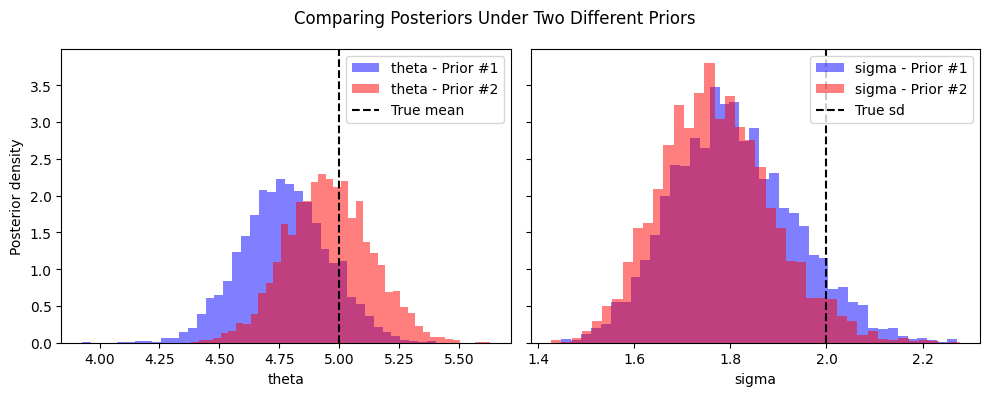

In [4]:
import numpy as np
from scipy.stats import norm, gamma
import matplotlib.pyplot as plt

def gibbs_sampler_normal_gamma(
    x,
    alpha=2.0,      # Gamma shape
    lam=2.0,        # Gamma rate
    theta0=0.0,     # Normal prior mean
    tau0=0.1,       # Normal prior precision
    n_iter=10_000,
    init_theta=0.0,
    init_tau=1.0
):
    """
    Gibbs sampler for a Normal(mean=theta, precision=tau) likelihood,
    with Normal-Gamma prior:
      theta ~ Normal(theta0, 1/tau0)
      tau   ~ Gamma(alpha, lam).

    Args:
        x:          1D array of observed data
        alpha:      shape parameter of Gamma prior for tau
        lam:        rate parameter of Gamma prior for tau
        theta0:     prior mean for theta
        tau0:       prior precision for theta
        n_iter:     number of MCMC iterations
        init_theta: initial value for theta
        init_tau:   initial value for tau (precision)

    Returns:
        thetas: array of sampled theta values
        taus:   array of sampled tau (precision) values
    """
    x = np.asarray(x)
    n = len(x)
    x_bar = np.mean(x)

    thetas = np.zeros(n_iter)
    taus   = np.zeros(n_iter)

    # Initialize
    thetas[0] = init_theta
    taus[0]   = init_tau

    for i in range(1, n_iter):
        # 1) Sample theta from its full conditional:
        #    p(theta | tau, x) ~ Normal(..., ...)
        tau_curr = taus[i-1]
        post_prec = n * tau_curr + tau0  # posterior precision
        post_mean = (n * tau_curr * x_bar + tau0 * theta0) / post_prec
        post_std  = np.sqrt(1.0 / post_prec)
        thetas[i] = norm.rvs(loc=post_mean, scale=post_std)

        # 2) Sample tau from its full conditional:
        #    p(tau | theta, x) ~ Gamma(..., ...)
        theta_curr = thetas[i]
        alpha_post = alpha + 0.5 * n
        # sum of squared errors
        sse = np.sum((x - theta_curr)**2)
        lam_post = lam + 0.5 * sse
        taus[i] = gamma.rvs(a=alpha_post, scale=1.0/lam_post)

    return thetas, taus


def demo_gibbs_sampler():
    # --- Generate synthetic data from some Normal(...) distribution ---
    np.random.seed(42)
    n = 100
    true_mean = 5.0
    true_sd   = 2.0
    x = norm(loc=true_mean, scale=true_sd).rvs(size=n)

    # --- First prior setup (e.g. fairly diffuse) ---
    alpha_1, lam_1   = 2.0, 2.0
    theta0_1, tau0_1 = 0.0, 0.1

    # Run Gibbs
    thetas_1, taus_1 = gibbs_sampler_normal_gamma(
        x,
        alpha=alpha_1,
        lam=lam_1,
        theta0=theta0_1,
        tau0=tau0_1,
        n_iter=5000
    )

    # --- Second prior setup (e.g. strong prior on smaller variance) ---
    alpha_2, lam_2   = 10.0, 20.0
    theta0_2, tau0_2 = 10.0, 1.0  # different mean & higher precision

    thetas_2, taus_2 = gibbs_sampler_normal_gamma(
        x,
        alpha=alpha_2,
        lam=lam_2,
        theta0=theta0_2,
        tau0=tau0_2,
        n_iter=5000
    )

    # Discard burn-in
    burn_in = 1000
    t1 = thetas_1[burn_in:]
    s1 = taus_1[burn_in:]
    t2 = thetas_2[burn_in:]
    s2 = taus_2[burn_in:]

    # Posterior estimates
    est_mean_1  = np.mean(t1)
    est_std_1   = np.mean(1.0/np.sqrt(s1))
    est_mean_2  = np.mean(t2)
    est_std_2   = np.mean(1.0/np.sqrt(s2))

    print(">>> Prior #1 (relatively diffuse) <<<")
    print(f"Posterior mean of theta = {est_mean_1:.2f}")
    print(f"Posterior mean of sigma = {est_std_1:.2f}  (sigma = 1/sqrt(tau))")

    print("\n>>> Prior #2 (stronger prior on smaller variance, different mean) <<<")
    print(f"Posterior mean of theta = {est_mean_2:.2f}")
    print(f"Posterior mean of sigma = {est_std_2:.2f}")

    # Quick plot
    fig, axs = plt.subplots(1, 2, figsize=(10,4), sharey=True)

    axs[0].hist(t1, bins=40, alpha=0.5, color="blue", density=True, label="theta - Prior #1")
    axs[0].hist(t2, bins=40, alpha=0.5, color="red", density=True, label="theta - Prior #2")
    axs[0].axvline(true_mean, color="k", linestyle="--", label="True mean")
    axs[0].set_xlabel("theta")
    axs[0].set_ylabel("Posterior density")
    axs[0].legend()

    axs[1].hist(1.0/np.sqrt(s1), bins=40, alpha=0.5, color="blue", density=True, label="sigma - Prior #1")
    axs[1].hist(1.0/np.sqrt(s2), bins=40, alpha=0.5, color="red", density=True, label="sigma - Prior #2")
    axs[1].axvline(true_sd, color="k", linestyle="--", label="True sd")
    axs[1].set_xlabel("sigma")
    axs[1].legend()

    plt.suptitle("Comparing Posteriors Under Two Different Priors")
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    demo_gibbs_sampler()

# Question 3
When using Bayes' rule, we know that if the prior $\pi(\theta)$ is a proper distribution, then the posterior distribution is proportional to the joint:
$
p(\theta \mid x) \;\propto\; \pi(\theta)\,p(x \mid \theta).
$
Conceptually, once you can write down $\pi(\theta)\cdot p(x \mid \theta)$, you already *have* the posterior: the exact distribution is visible as soon as you look at the product of the prior and likelihood, up to the normalizing constant. If the forms of the prior and likelihood are familiar (e.g., conjugate families), you can often identify a known closed-form posterior distribution.



However, in practice---especially in complex models---this knowledge is mostly moot because Bayesians typically rely on sampling (e.g., via MCMC) from the posterior rather than manipulating its algebraic form. Ultimately, what we care about is the numerical approximation of this distribution: we collect samples, use them to build histograms or compute summary statistics (means, intervals, etc.), and then turn those into probability (credible) statements about $\theta$.



So, while the posterior is ``exactly'' known in principle by its proportional relationship to the joint, the real work often comes in drawing samples and interpreting them---making the functional details of the posterior far less critical than our ability to simulate from it.
